In [1]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from stingray.pulse import epoch_folding_search
from stingray.pulse import get_orbital_correction_from_ephemeris_file
import Important_Functions as IF
import scipy.stats as st

/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:25: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:40: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


## Importing data

In [2]:
#Retrieving data for source file
Time_phase_file = pf.open('sourceA.evt')

#Getting event arrival time data
Time_phase_data=Time_phase_file[1].data

## Getting GTIs

In [3]:
#Retrieving the GTIs
GTI_phase_file = Time_phase_file[2]

#Re-formatting the GTIs so that we can use them in the Stingray package
new_gtis=[]
for i in GTI_phase_file.data:
    new_gtis.append((i['START'], i['STOP']))


## Getting the event arrival times taking into account the orbital correction

In [4]:
#Setting up the parameters used by the Stingray documentation to correct the event arrival times

#Reference time in MJD
base_time = Time_phase_file[1].header['MJDREFI']+Time_phase_file[1].header['MJDREFF']

#Start time of observations in seconds
start_time = Time_phase_file[1].header['TSTART']/(24*3600)

#End time of observations in seconds
end_time = Time_phase_file[1].header['TSTOP']/(24*3600)

#Getting the correct_time function from the parameters defined above 
#and the orbit_t2.txt file containing the orbital parameters of Cen-X3
correct_time = get_orbital_correction_from_ephemeris_file(base_time+start_time, base_time+end_time, parfile='orbit_t2.txt')[0]

#Applying the correct_time function to our event arrival times
correct_orbit_time = correct_time(Time_phase_file[1].data['TIME'], base_time)



/opt/anaconda3/envs/testenv/lib/python3.10/site-packages/stingray/utils.py:142: UserWarning: SIMON says: Assuming events are already referred to the solar system barycenter (timescale is TDB)
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
2022-10-10 17:23:38.325 | DEBUG    | pint.toa:__init__:1310 - No pulse number flags found in the TOAs
2022-10-10 17:23:38.326 | DEBUG    | pint.toa:compute_TDBs:2139 - Computing TDB columns.
2022-10-10 17:23:38.326 | DEBUG    | pint.toa:compute_TDBs:2164 - Using EPHEM = DE405 for TDB calculation.
2022-10-10 17:23:38.394 | DEBUG    | pint.toa:compute_posvels:2255 - Computing PosVels of observatories and Earth, using DE405
2022-10-10 17:23:38.402 | DEBUG    | pint.toa:compute_posvels:2310 - SSB obs pos [0. 0. 0.] m
2022-10-10 17:23:39.172 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:54 - Set solar system ephemeris to de405 from download
2022-10-10 17:23:39.199 | DEBUG    | pint.toa:compute_posvels:2324 - Adding columns ssb_

## Using the event arrival times with orbital correction and the Stingray function epoch_folding_search to find pulse frequency

In [5]:
#Defining frequencies to try - required for epoch_folding_search
#Can either take a large range but then the resolution is low
#Or small range with high resolution -> could maybe do this iteratively
trial_freqs = np.linspace(0.208, 0.209, 1000)

#Getting the power as a function of frequency from 1. the event arrival times and 
#2. the event arrival times with orbital correction to show the difference

L = epoch_folding_search(Time_phase_data['TIME'], trial_freqs, gti=new_gtis)

correct_L = epoch_folding_search(correct_orbit_time, trial_freqs, segment_size=20000, gti=new_gtis)

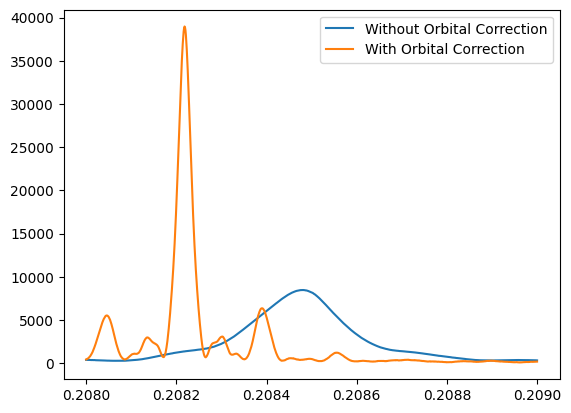

In [6]:
#Plotting the power as a function energy
plt.plot(L[0], L[1], label='Without Orbital Correction')
plt.plot(correct_L[0], correct_L[1], label='With Orbital Correction')
plt.legend()

# Getting the pulse profile matrix with orbitally corrected time segments

## Segmenting data

In [7]:
# We separate the data into 20 segments 

#We change the number of events we use 
#so that it can be divided by 20
size=1387000

#Getting corresponding sizes of bins
seg_size = int(size/20)

#Making lists that will contain the 20 segments of time and PI data
#We extract the PI data to get the periodogram for each segment.
Time_segments = []
PI_segments = []

#Populating the time and PI segment lists
for i in range(20):
    Time_segments.append(correct_orbit_time[seg_size*i:seg_size*(i+1)])
    PI_segments.append(Time_phase_data['PI'][seg_size*i:seg_size*(i+1)])


## Get the periodogram for the segments

In [8]:
freq_seg, power_seg = IF.get_power_and_freq(Time_segments, PI_segments, 20)

## Getting the first harmonic frequencies and regression coefficients

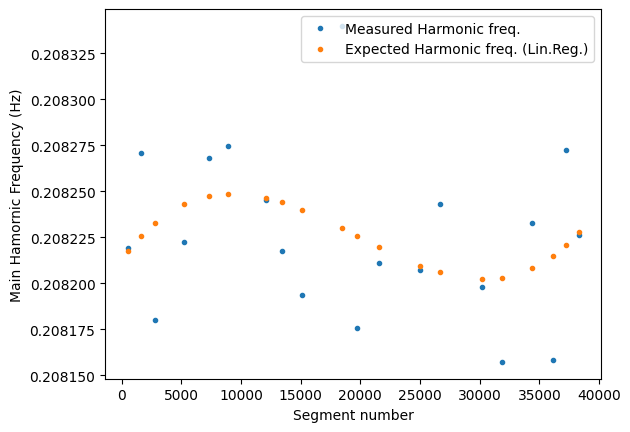

In [9]:
reg, bins = IF.Harmonic_funk(3, 0.01, Time_phase_data['TIME'][0], Time_segments, freq_seg, power_seg)

## Getting the pulse profile matrix

39
32
34
37
29
31
33
33
37
33
33
26
30
36
28
34
28
32
34
27


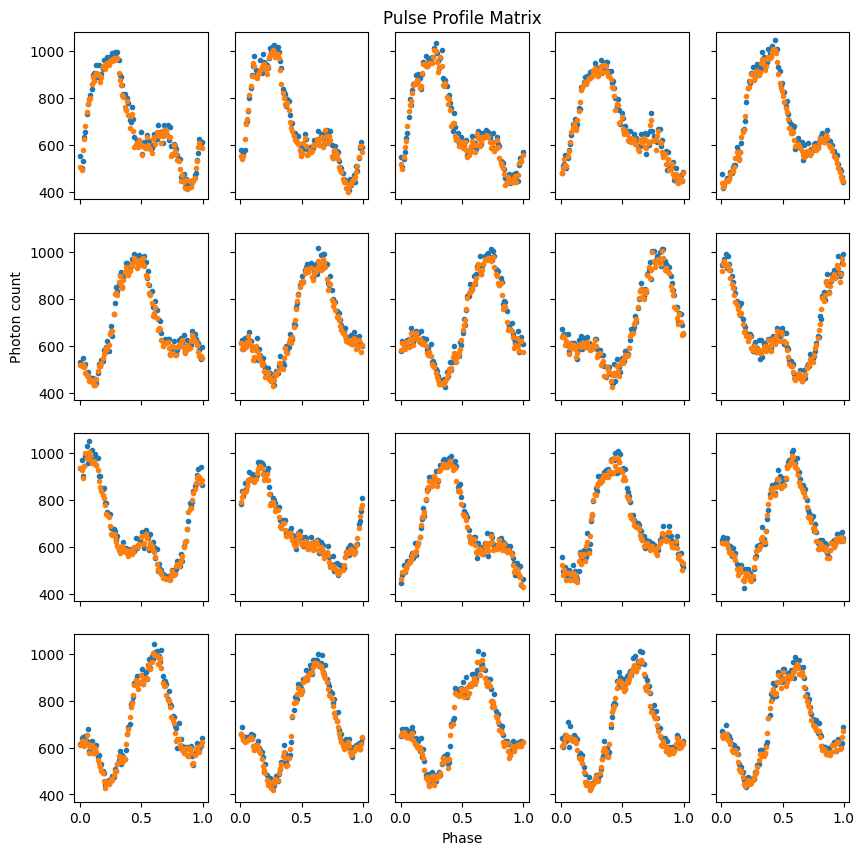

In [10]:
orders, model_phases, counts, phases = IF.pulse_profile_matrix(Time_segments, Time_phase_data['TIME'][0], reg)

# Getting the ENERGY pulse profile matrix

In [11]:
#Getting sizes of bins

#nmin and nmax are the minimum and maximum values of the energies we are considering
#time_data and energy_data are the arrays containing the energy and time data
#nbin is the number of segments we want to make -> if nbin negative use logarithmic
                                                #-> if nbin positive use linear
def segment_energywise(time_data, energy_data, nmin, nmax, nbin):
    if nbin<0:
        size_bin = mt.floor(np.log(nmax-nmin)/nbin)
    else:
        size_bin = mt.floor((nmax-nmin)/nbin)
    energy_time_segments = []
    energy_time_segment = []
    energy_segments = []
    energy_segment = []
    if nbin<0:
        for i in range(nbin):
            for j in range(len(energy_data)):
                if np.exp(size_bin)*i*40 < Time_phase_file[1].data['PI'][j] < np.exp(size_bin)*(i+1)*40:
                    energy_segment.append(Time_phase_file[1].data['PI'][j]*40)
                    energy_time_segment.append(correct_orbit_time[j])
            energy_segments.append(energy_segment)
            energy_time_segments.append(energy_time_segment)
            energy_time_segment=[]
            energy_segment=[]
    else: 
        for i in range(nbin):
            for j in range(len(energy_data)):
                if size_bin*i < Time_phase_file[1].data['PI'][j] < size_bin*(i+1):
                    energy_segment.append(Time_phase_file[1].data['PI'][j]*40)
                    energy_time_segment.append(correct_orbit_time[j])
            energy_segments.append(energy_segment)
            energy_time_segments.append(energy_time_segment)
            energy_time_segment=[]
            energy_segment=[]
    return energy_time_segments, energy_segments

energy_time_segments, energy_segments = segment_energywise(correct_orbit_time, Time_phase_data['PI'], 3, 70, 5)


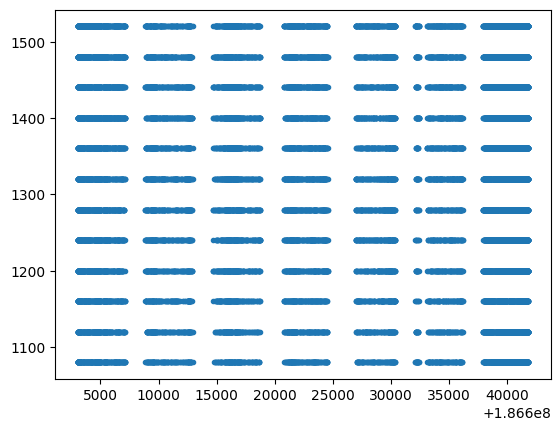

In [12]:
plt.plot(energy_time_segments[2], energy_segments[2], '.')

37


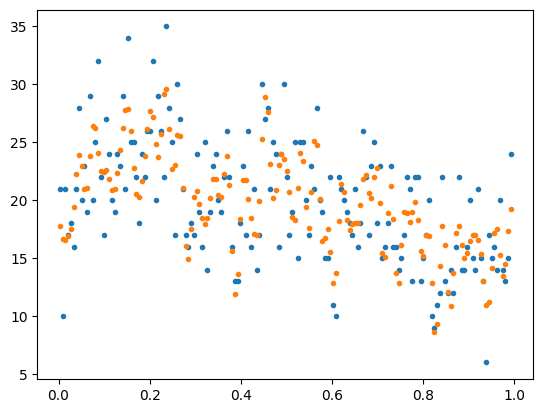

39


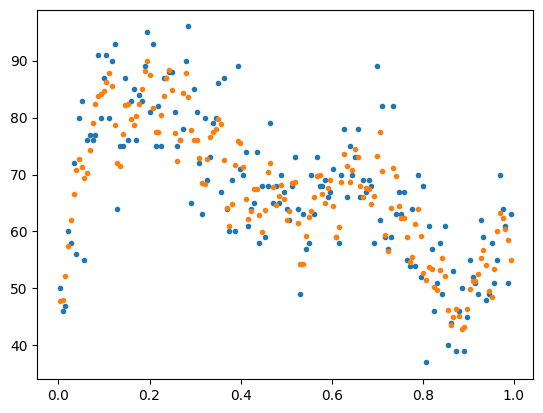

40


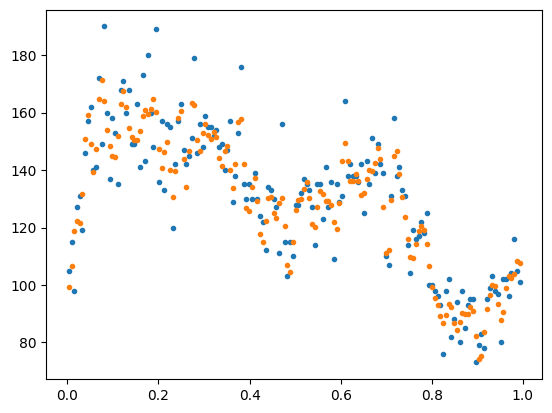

37


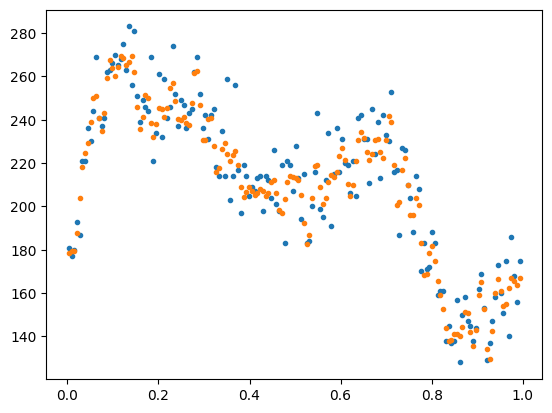

36


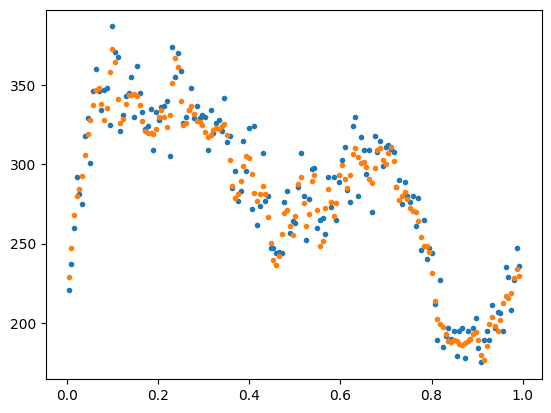

In [14]:
#Getting the periodogram for the two segment

#energy_freq_seg, energy_power_seg = IF.get_power_and_freq(energy_time_segments, energy_segments, 2)

guess_freq = correct_L[0][np.argmax(correct_L[1])]

energy_orders, energy_model_phases, energy_counts, energy_phase=IF.pulse_profile_matrix(energy_time_segments, Time_phase_data['TIME'][0], [guess_freq], True, 5, 0.006)





In [16]:
print(len(energy_counts[0]), len(energy_phase[1]))

166 166


## Using bootstrap method to find the uncertainty on the phase 

166
The phase of first harmonic is -1.8420578932593363 +/- 0.019119516477358232
The phase of first harmonic is -1.8121536390090334 +/- 0.0071044779975353465
The phase of first harmonic is -1.9220256334157748 +/- 0.0029905577464589017
The phase of first harmonic is -1.9345216019190385 +/- 0.0027227075160260136
The phase of first harmonic is -1.875971039636569 +/- 0.0015344032527637949


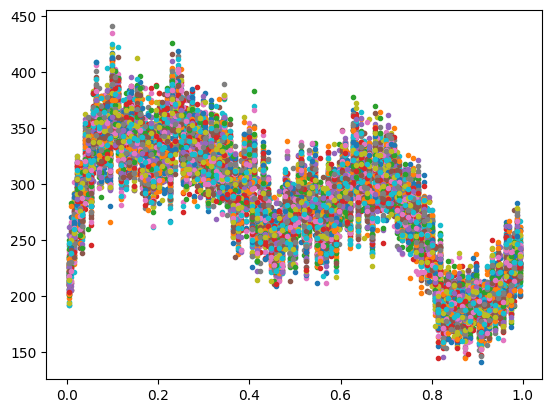

In [20]:
#Get the phase uncertainty for first harmonic for a given pulse profile using 
#k realizations of said pulse profile.
#k: number of realizations
#pulse_profile: bin times and counts per bin
def bootstrap(pulse_profile, k):
    #Getting the time and counts data
    time, counts = pulse_profile
    
    #Setting up lists for the fake pulse profile values
    #and matrix multiplication step as well as the k realizations 
    #of the first harmonic phase
    fake_profiles = []
    fake_profile = []
    row=[]
    phases_k=[]
        
    #Getting the actual phase of first harmonic for the pulse profile we are considering
    #to make sure our results are sensible 
    true_phase = np.arctan2(np.fft.rfft(counts).imag, np.fft.rfft(counts).real)[1]
        
    #Making k realizations of our pulse profile using a Poisson distibution centered
    #on the number of photon counts of each point in the pulse profile.
    for i in range(len(counts)):
        fake_profile.append(st.poisson.rvs(mu=counts[i], size=k))
        
    #Re-making the k realizations so that instead of having an n x k matrix 
    #We have a k x n matrix -> will make it easier to plot the k realizations of the 
    #pulse profile.
    for j in range(k):
        for i in range(len(fake_profile)):
            row.append(fake_profile[i][j])
        fake_profiles.append(row)
        row=[]
    
    #Calculating the phase of first harmonic for the k realizations 
    #and populating the phases_k list. 
    for l in range(len(fake_profiles)):
        fft = np.fft.rfft(fake_profiles[l])
        phase_l = np.arctan2(fft.imag, fft.real)
        phases_k.append(phase_l[1])
        
    #Getting the standard deviation of our phase measurement using the 
    #bootstrapping method)
    std = (1/k)*np.sum((np.array(phases_k)-np.mean(phases_k))**2)
    
     
    return fake_profiles, std, true_phase

test = bootstrap((energy_phase[4], energy_counts[4]), 100)
#print('The true phase is ', test[2], ' The guessed phase is ', test[0], 'and the uncertainty on true phase is ',test[1])
print(len(energy_counts[3]))
for i in range(len(test[0])):
    plt.plot(energy_phase[4], test[0][i], '.')
    
for i in range(len(energy_phase)):
    temp2 = bootstrap((energy_phase[i], energy_counts[i]), 100)
    print('The phase of first harmonic is', temp2[2], '+/-', temp2[1])